This notebook is devoted to implementing periodic boundary conditions. These boundary conditions are often used to approximate a very large system by taking a small region, called a unit cell, which can be replicated over the entire system, hence the term periodic. 

Firstly, we describe the equation we would like to solve:

$$ \frac{\partial U}{\partial t} + a \frac{\partial U}{\partial x} = 0, $$
where $U = u_mh_m$.

Mathematically, periodic boundary conditions means that the solution should be periodic in this large system, i.e., if we take a domain and apply periodic boundary conditions, this domain will be one of the many copies, stacked one after the other. When we deal with the central difference scheme, we end with two unknowns, at each of the extremes. If our unit cell comprises of N grid points, labelled as $x_1,x_2,x_3...,x_N$, then the 0th grid point should actually be equal to the Nth grid point, and the (N+1)th grid point should be equal to the 1st grid point. For an arbitrary function $f(x)$, this can be stated as:

$$ f(x = x_1) = f(x = x_N+1), $$

$$ f(x = x_N) = f(x = 0).$$

The general form of analytical solution for this equation is:

$$ U(x,t) = A \sin [k(x - a t)] + B. $$

We consider a full sine wave (so that we can apply periodic boundary conditions, and we check a specific solution:

$$ U(x,t) = 0.5 \sin \Big(\frac{2 \pi x}{L_x} \Big) + 0.5. $$

For both cases, the numerical and analytical solution match.

# Test 1: Solving a "pseudo-conservative" form

In this case, we do solve the equation mentioned above, but during the itertion, we solve for $u_mh_m$ by dividing the whole equation with $h_m$.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [59]:
Lx = 100
nx = 40
dx = Lx/nx
g = 9.81
rho0 = 1025

x = np.linspace(0, Lx, nx+1, dtype = float)
x = x[0:-1] # drops the last point x=Lx

In [60]:
dfdx = np.zeros_like(x)
dfdx

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [61]:
x.size

40

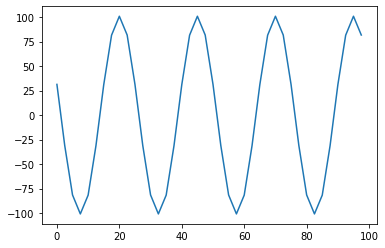

In [104]:
def partial_x(f, dx):
    dfdx = np.zeros_like(f)
    for j in range(f.size):
        dfdx[j] = 1/(dx) * (f[j]-f[j-1])


#     for j in range(f.size-1):
#         dfdx[j] = 1/(2*dx) * (f[j+1]-f[j-1])
    
#     dfdx[-1] = 1/(2*dx) * (f[0]-f[-2])
    
    #dfdx = 1/(2*dx) *(f[2:nx] - f[0:nx-2])
    return dfdx

f = 2 * np.cos(4*2*np.pi/Lx * x)

dfdx = partial_x(f, dx)
dfdx_theoretical = - 2 * 4*2*np.pi/Lx * np.sin(4*2*np.pi/Lx * x)
plt.plot(x, dfdx-dfdx_theoretical)

In [105]:
def adv_x_Euler(f1,hm_old,hm_new):
    #f3 = -(1/hm_new[1:nx-1])*partial_x(hm_old*f1**2,dx)
#     f3 = -(1/hm_new[1:nx-1])*a*partial_x(hm_old*f1,dx)

    f3 = -a * partial_x(f1, dx)

    return f3

In [87]:
MLD_0 = -150*np.ones(nx)

u0 = 0.5*(np.sin(2*np.pi*x/(Lx)) + 1)
um_old = 0.5*(np.sin(2*np.pi*x/(Lx)) + 1)
um_new = np.zeros(nx)
hm_old = -MLD_0
hm_new = hm_old
a = 0.5 #Speed of advection

dt = 1.3
nsteps = 80

t_start = 0.0
t_end = nsteps*dt

distance = a * (t_end-t_start)


BC = 0.5*(np.sin(2*np.pi*x/(Lx)) + 1)

for iteration in range(nsteps):
    if iteration==0:
        um_new = um_old + dt * adv_x_Euler(um_old, hm_old, hm_new)
        um_old = um_new
    else:
        

# BC = 0.5*(np.sin(2*np.pi*xu_ocean/(Lx)) + 1)

# for t in np.arange(t_start, t_end, dt):
#     um_new[1:nx-1] = um_old[1:nx-1] + dt * adv_x_Euler(um_old, hm_old, hm_new)
    
#     #um_new[0] = um_new[1]
#     #um_new[-1] = um_new[-2]
#     BC = 0.5*(np.sin(2*np.pi*(xu_ocean - a*(t))/(Lx)) + 1)
    
#     um_new[0] = BC[0]
#     um_new[-1] = BC[-1]
#     um_old = um_new

In [88]:
np.arange(t_start, t_end, dt)

array([  0. ,   1.3,   2.6,   3.9,   5.2,   6.5,   7.8,   9.1,  10.4,
        11.7,  13. ,  14.3,  15.6,  16.9,  18.2,  19.5,  20.8,  22.1,
        23.4,  24.7,  26. ,  27.3,  28.6,  29.9,  31.2,  32.5,  33.8,
        35.1,  36.4,  37.7,  39. ,  40.3,  41.6,  42.9,  44.2,  45.5,
        46.8,  48.1,  49.4,  50.7,  52. ,  53.3,  54.6,  55.9,  57.2,
        58.5,  59.8,  61.1,  62.4,  63.7,  65. ,  66.3,  67.6,  68.9,
        70.2,  71.5,  72.8,  74.1,  75.4,  76.7,  78. ,  79.3,  80.6,
        81.9,  83.2,  84.5,  85.8,  87.1,  88.4,  89.7,  91. ,  92.3,
        93.6,  94.9,  96.2,  97.5,  98.8, 100.1, 101.4, 102.7])

Text(0.5, 1.0, 'Backward difference')

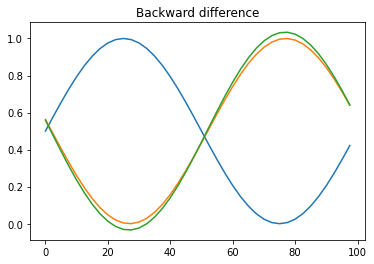

In [91]:

u_theoretical = 0.5*(np.sin(2*np.pi*(x-distance)/(Lx)) + 1)

plt.plot(x, u0)
plt.plot(x, u_theoretical, label='theoretical')
plt.plot(x, um_old)
plt.title('Backward difference')

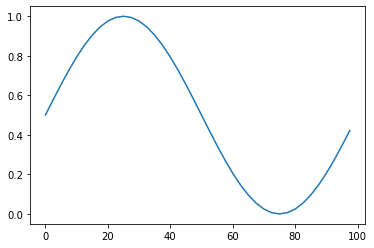

In [81]:
plt.plot(x, BC)

Text(0.5, 1.0, 'Central difference')

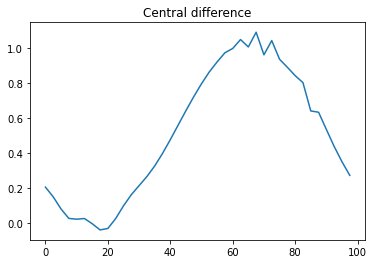

In [96]:
plt.plot(xu_ocean,um_new)
plt.title('Central difference')

# Test 2: Using the real conservative form

In this case, we solve the fully conservative form, i.e., we solve for $U$. In both the cases, we see that the central difference starts to induce oscillations from the boundaries. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
Lx = 100
nx = 50
dx = Lx/nx
g = 9.81
rho0 = 1025

xu_ocean = np.linspace(0,Lx,nx+1,dtype = float)
xu_ocean = xu_ocean[0:-1]

In [132]:
def partial_x(f,dx):
    dfdx = 1/(dx) * (f[1:nx-1] - f[0:nx-2])  #Backward differerence, stable for positive advection velocity
    #dfdx = 1/(2*dx) *(f[2:nx] - f[0:nx-2])
    return dfdx

def adv_x_Euler(f1):
    a = 0.5 #Speed of advection
    f3 = -a*partial_x(f1,dx)
    return f3

In [ ]:
MLD_0 = -150*np.ones(nx)

hm_old = -MLD_0
hm_new = hm_old
U_old = (0.5*(np.sin(2*np.pi*xu_ocean/(Lx)) + 1))*(hm_old)
U_new = np.zeros(nx)

a = 0.5 #Speed of advection

t_start = 0
t_end = 80
dt = 2
for t in np.arange(t_start,t_end,dt):
    U_new[1:nx-1] = U_old[1:nx-1] + dt*adv_x_Euler(U_old)
    
    #um_new[0] = um_new[1]
    #um_new[-1] = um_new[-2]
    
    BC = (0.5*(np.sin(2*np.pi*(xu_ocean - a*t)/(Lx)) + 1))*hm_new
    
    U_new[0] = BC[0]
    U_new[-1] = BC[-1]
    U_old = U_new

In [133]:
MLD_0 = -150*np.ones(nx)

hm_old = -MLD_0
hm_new = hm_old
U_old = (0.5*(np.sin(2*np.pi*xu_ocean/(Lx)) + 1))*(hm_old)
U_new = np.zeros(nx)

a = 0.5 #Speed of advection

t_start = 0
t_end = 80
dt = 2
for t in np.arange(t_start,t_end,dt):
    U_new[1:nx-1] = U_old[1:nx-1] + dt*adv_x_Euler(U_old)
    
    #um_new[0] = um_new[1]
    #um_new[-1] = um_new[-2]
    
    BC = (0.5*(np.sin(2*np.pi*(xu_ocean - a*t)/(Lx)) + 1))*hm_new
    
    U_new[0] = BC[0]
    U_new[-1] = BC[-1]
    U_old = U_new

Text(0.5, 1.0, 'Velocity - Backward difference (m/s)')

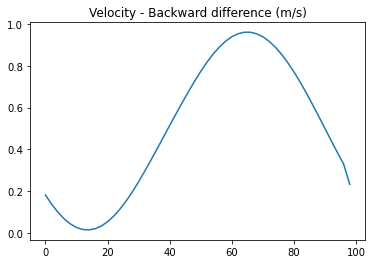

In [134]:
plt.plot(xu_ocean,U_new/hm_new)
plt.title('Velocity - Backward difference (m/s)')

Text(0.5, 1.0, 'Depth integrated velocity - Backward difference (m^2/s)')

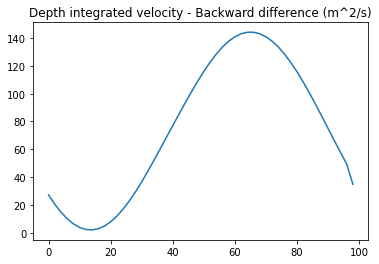

In [135]:
plt.plot(xu_ocean,U_new)
plt.title('Depth integrated velocity - Backward difference (m^2/s)')

Text(0.5, 1.0, 'Depth integrated velocity - Central difference (m^2/s)')

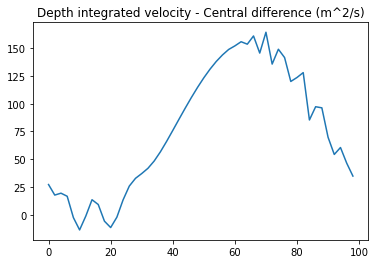

In [131]:
plt.plot(xu_ocean,U_new)
plt.title('Depth integrated velocity - Central difference (m^2/s)')

Text(0.5, 1.0, 'Depth integrated velocity - Analytical solution')

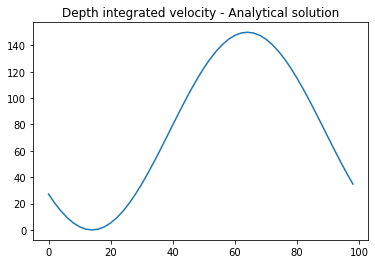

In [136]:
plt.plot(xu_ocean,BC)
plt.title('Depth integrated velocity - Analytical solution')

# Test 3: Error analysis

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [128]:
def partial_x(f, dx):
    dfdx = np.zeros_like(f)
    for j in range(f.size):
        dfdx[j] = 1/(dx) * (f[j]-f[j-1])

    return dfdx


def adv_x_Euler(f1):
    a = 0.5 #Speed of advection
    f3 = -a*partial_x(f1, dx)
    return f3

Lx = 100
g = 9.81
rho0 = 1025

nx = [4,8,32,64,128,256,512,1024,2048,4096,8192]
error_U = np.zeros(len(nx))

for i,nxi in enumerate(nx):
    print(nxi)
    dx = Lx/nxi
    
    x = np.linspace(0,Lx, nxi+1,dtype = float)
    x = x[0:-1]
    
    MLD_0 = -150*np.ones(nxi)

    hm_old = -MLD_0
    hm_new = hm_old
    U_old = (0.5*(np.sin(2*np.pi*x/(Lx)) + 1))*(hm_old)
    U_new = np.zeros(nxi)

    a = 0.5 #Speed of advection

    t_start = 0
    t_end = 0.6
    dt = 0.5/nxi
    for t in np.arange(t_start, t_end, dt):
        U_new = U_old + dt*adv_x_Euler(U_old)
        U_old = U_new
        
    BC = (0.5*(np.sin(2*np.pi*(x - a*t)/(Lx)) + 1))*hm_new
    error_U[i] = np.sqrt(np.sum(abs(U_new - BC)**2)) / np.sqrt(np.sum(abs(BC)**2))

4
8
32
64
128
256
512
1024
2048
4096
8192


In [129]:
error_U_cd = error_U

In [130]:
error_U_bd = error_U

In [131]:
nx_inv = np.zeros(len(nx))
nx2_inv = np.zeros(len(nx))
for i,nxi in enumerate(nx):
    nx_inv[i] = 1/nxi
    nx2_inv[i] = 1/nxi**2

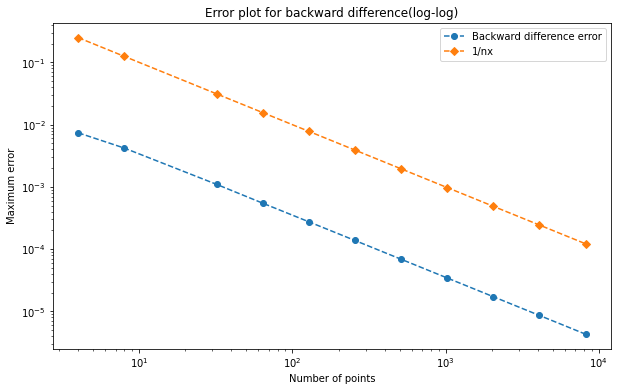

In [132]:
plt.figure(figsize = (10,6))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of points")
plt.ylabel("Maximum error")
plt.plot(nx,error_U_bd,marker='o',linestyle = '--',label = 'Backward difference error')
plt.plot(nx,nx_inv,marker = 'D',linestyle = '--', label = '1/nx')
plt.title("Error plot for backward difference(log-log)")
plt.legend()
plt.show()

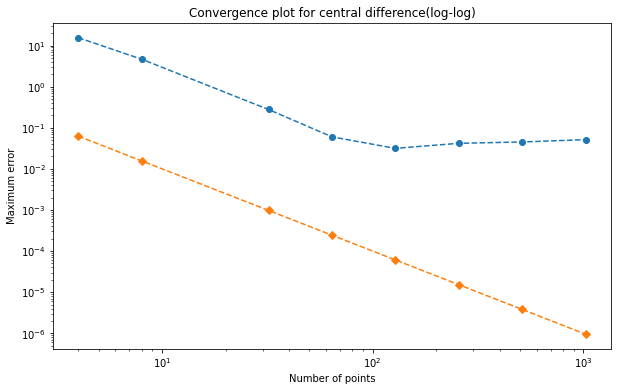

In [68]:
plt.figure(figsize = (10,6))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of points")
plt.ylabel("Maximum error")
plt.plot(nx[0:8],error_U_cd[0:8],marker='o',linestyle='--',label = 'Central difference error')
plt.plot(nx[0:8],nx2_inv[0:8],marker = 'D', linestyle = '--',label = '1/nx^2')
plt.title("Error plot for central difference(log-log)")
plt.show()